![Colegio Bourbaki](./Images/Bourbaki.png)

## Procesamiento de Lenguaje Natural

### LLM Fine Tuning

### Contexto

Conjunto de datos **TravelPlanner**:

TravelPlanner es un punto de referencia elaborado para evaluar a los agentes lingüísticos en el uso de herramientas y la planificación compleja dentro de múltiples restricciones. Paper: https://arxiv.org/pdf/2402.01622.pdf

Introducción

En TravelPlanner, para una consulta determinada, se espera que los agentes lingüísticos formulen un plan completo que incluya transporte, comidas diarias, atracciones y alojamiento para cada día.

TravelPlanner comprende 1.225 consultas en total. El número de días y las restricciones duras se han diseñado para poner a prueba las capacidades de los agentes tanto en la amplitud como en la profundidad de una planificación compleja.

Conjunto de entrenamiento: 5 consultas con sus correspondientes planes anotados por humanos para cada grupo, lo que da un total de 45 pares de consulta-plan. Este conjunto proporciona los planes anotados por humanos como demostraciones para el aprendizaje en contexto.

Conjunto de validación: 20 consultas de cada grupo, lo que supone un total de 180 consultas. En este conjunto no hay ningún plan anotado por humanos.

Conjunto de prueba: 1.000 consultas distribuidas aleatoriamente. Para evitar la contaminación de los datos, sólo proporcionamos el nivel, los días y los campos de consulta en lenguaje natural.

Schema:

    "org": The city from where the journey begins.
    "dest": The destination city.
    "days": The number of days planned for the trip.
    "visiting_city_number": The total number of cities included in the itinerary.
    "date": The specific date when the travel is scheduled.
    "people_number": The total number of people involved in the travel.
    "local_constraint": The local hard constraint, including house rule, cuisine, room type and transportation.
    "query": A natural language description or request related to the travel plan.
    "level": The difficulty level, which is determined by the number of hard constraints.
    "annotated_plan": A detailed travel plan annotated by a human, ensuring compliance with all common sense requirements and specific hard constraints.
    "reference_information": Reference information for "sole-planning" mode.


In [ ]:
!pip install datasets, ast, transformers

### Librerías

In [1]:
#Hugging Face Datasets
from datasets import load_dataset

#Torch
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Text Processing
import ast
from transformers import GPT2Tokenizer, GPT2LMHeadModel

#Utils
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import sys
from tqdm.notebook import tqdm  # Display progress bar

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Configuraciones

In [3]:
# Set seed for random generators
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [4]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
!set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:2'
torch.cuda.empty_cache()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
device

'cuda:0'

In [7]:
print("__Python VERSION:", sys.version)
print("__pyTorch VERSION:", torch.__version__, end="\n\n")

if torch.cuda.is_available():
    #print("__CUDA VERSION")
    #! nvcc --version
    print("__CUDNN VERSION:", torch.backends.cudnn.version())
    print("__Number CUDA Devices:", torch.cuda.device_count())
    print("__Devices:")
    print("Active CUDA Device: GPU", torch.cuda.current_device())
    print("Available devices ", torch.cuda.device_count())
    print("Current cuda device ", torch.cuda.current_device())
    #! nvidia-smi

__Python VERSION: 3.11.7 (main, Dec 29 2023, 12:40:11) [GCC 11.4.0]
__pyTorch VERSION: 2.1.2+cu121

__CUDNN VERSION: 8902
__Number CUDA Devices: 1
__Devices:
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [8]:
data_train = load_dataset('osunlp/TravelPlanner', 'train', trust_remote_code=True)
data_val = load_dataset('osunlp/TravelPlanner', 'validation', trust_remote_code=True)
data_test = load_dataset('osunlp/TravelPlanner', 'test', trust_remote_code=True)

In [9]:
data_train

DatasetDict({
    train: Dataset({
        features: ['org', 'dest', 'days', 'visiting_city_number', 'date', 'people_number', 'local_constraint', 'budget', 'query', 'level', 'annotated_plan', 'reference_information'],
        num_rows: 45
    })
})

In [10]:
data_val

DatasetDict({
    validation: Dataset({
        features: ['org', 'dest', 'days', 'visiting_city_number', 'date', 'people_number', 'local_constraint', 'budget', 'query', 'level', 'reference_information'],
        num_rows: 180
    })
})

In [11]:
data_test

DatasetDict({
    test: Dataset({
        features: ['days', 'level', 'query', 'reference_information'],
        num_rows: 1000
    })
})

In [12]:
df_train = data_train['train'].to_pandas()
df_val = data_val['validation'].to_pandas()
df_test = data_test['test'].to_pandas()

In [13]:
df_train.head()

,org,dest,days,visiting_city_number,date,people_number,local_constraint,budget,query,level,annotated_plan,reference_information
0,St. Petersburg,Rockford,3,1,"['2022-03-16', '2022-03-17', '2022-03-18']",1,"{'house rule': None, 'cuisine': None, 'room ty...",1700,Please help me plan a trip from St. Petersburg...,easy,"[{'org': 'St. Petersburg', 'dest': 'Rockford',...","[{'Description': 'Attractions in Rockford', 'C..."
1,Kansas City,Pensacola,3,1,"['2022-03-27', '2022-03-28', '2022-03-29']",1,"{'house rule': None, 'cuisine': None, 'room ty...",900,Can you provide a travel plan for 1 person dep...,easy,"[{'org': 'Kansas City', 'dest': 'Pensacola', '...","[{'Description': 'Attractions in Pensacola', '..."
2,Las Vegas,Stockton,3,1,"['2022-03-03', '2022-03-04', '2022-03-05']",1,"{'house rule': None, 'cuisine': None, 'room ty...",1400,Please design a travel plan departing from Las...,easy,"[{'org': 'Las Vegas', 'dest': 'Stockton', 'day...","[{'Description': 'Attractions in Stockton', 'C..."
3,New Orleans,Louisville,3,1,"['2022-03-12', '2022-03-13', '2022-03-14']",1,"{'house rule': None, 'cuisine': None, 'room ty...",1900,Craft a travel plan for me to depart from New ...,easy,"[{'org': 'New Orleans', 'dest': 'Louisville', ...","[{'Description': 'Attractions in Louisville', ..."
4,Las Vegas,Denver,3,1,"['2022-03-12', '2022-03-13', '2022-03-14']",1,"{'house rule': None, 'cuisine': None, 'room ty...",1600,Please provide me with a travel plan that depa...,easy,"[{'org': 'Las Vegas', 'dest': 'Denver', 'days'...","[{'Description': 'Attractions in Denver', 'Con..."


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   org                    45 non-null     object
 1   dest                   45 non-null     object
 2   days                   45 non-null     int64 
 3   visiting_city_number   45 non-null     int64 
 4   date                   45 non-null     object
 5   people_number          45 non-null     int64 
 6   local_constraint       45 non-null     object
 7   budget                 45 non-null     int64 
 8   query                  45 non-null     object
 9   level                  45 non-null     object
 10  annotated_plan         45 non-null     object
 11  reference_information  45 non-null     object
dtypes: int64(4), object(8)
memory usage: 4.3+ KB


In [15]:
data_str = df_train['reference_information'][0]
data = ast.literal_eval(data_str) 
data

[{'Description': 'Attractions in Rockford',
  'Content': "                                   Name  Latitude  Longitude                                                          Address          Phone                                                                 Website     City\n       Burpee Museum of Natural History 42.277324 -89.088142                           737 N Main St, Rockford, IL 61103, USA (815) 965-3433                                                  http://www.burpee.org/ Rockford\n                  Midway Village Museum 42.280499 -88.984640                        6799 Guilford Rd, Rockford, IL 61107, USA (815) 397-9112                                          https://www.midwayvillage.com/ Rockford\n                Discovery Center Museum 42.277105 -89.089430                           711 N Main St, Rockford, IL 61103, USA (815) 963-6769                                   http://www.discoverycentermuseum.org/ Rockford\nTinker Swiss Cottage Museum and Gardens 42.264110 

In [16]:
df_train['formatted_reference_information'] = df_train['reference_information'].apply(lambda x: ast.literal_eval(x))
df_train['formatted_annotated_plan'] = df_train['annotated_plan'].apply(lambda x: ast.literal_eval(x))

In [17]:
df_train.head()

,org,dest,days,visiting_city_number,date,people_number,local_constraint,budget,query,level,annotated_plan,reference_information,formatted_reference_information,formatted_annotated_plan
0,St. Petersburg,Rockford,3,1,"['2022-03-16', '2022-03-17', '2022-03-18']",1,"{'house rule': None, 'cuisine': None, 'room ty...",1700,Please help me plan a trip from St. Petersburg...,easy,"[{'org': 'St. Petersburg', 'dest': 'Rockford',...","[{'Description': 'Attractions in Rockford', 'C...","[{'Description': 'Attractions in Rockford', 'C...","[{'org': 'St. Petersburg', 'dest': 'Rockford',..."
1,Kansas City,Pensacola,3,1,"['2022-03-27', '2022-03-28', '2022-03-29']",1,"{'house rule': None, 'cuisine': None, 'room ty...",900,Can you provide a travel plan for 1 person dep...,easy,"[{'org': 'Kansas City', 'dest': 'Pensacola', '...","[{'Description': 'Attractions in Pensacola', '...","[{'Description': 'Attractions in Pensacola', '...","[{'org': 'Kansas City', 'dest': 'Pensacola', '..."
2,Las Vegas,Stockton,3,1,"['2022-03-03', '2022-03-04', '2022-03-05']",1,"{'house rule': None, 'cuisine': None, 'room ty...",1400,Please design a travel plan departing from Las...,easy,"[{'org': 'Las Vegas', 'dest': 'Stockton', 'day...","[{'Description': 'Attractions in Stockton', 'C...","[{'Description': 'Attractions in Stockton', 'C...","[{'org': 'Las Vegas', 'dest': 'Stockton', 'day..."
3,New Orleans,Louisville,3,1,"['2022-03-12', '2022-03-13', '2022-03-14']",1,"{'house rule': None, 'cuisine': None, 'room ty...",1900,Craft a travel plan for me to depart from New ...,easy,"[{'org': 'New Orleans', 'dest': 'Louisville', ...","[{'Description': 'Attractions in Louisville', ...","[{'Description': 'Attractions in Louisville', ...","[{'org': 'New Orleans', 'dest': 'Louisville', ..."
4,Las Vegas,Denver,3,1,"['2022-03-12', '2022-03-13', '2022-03-14']",1,"{'house rule': None, 'cuisine': None, 'room ty...",1600,Please provide me with a travel plan that depa...,easy,"[{'org': 'Las Vegas', 'dest': 'Denver', 'days'...","[{'Description': 'Attractions in Denver', 'Con...","[{'Description': 'Attractions in Denver', 'Con...","[{'org': 'Las Vegas', 'dest': 'Denver', 'days'..."


In [18]:
df_train['formatted_annotated_plan'][0]

[{'org': 'St. Petersburg',
  'dest': 'Rockford',
  'days': 3,
  'visiting_city_number': 1,
  'date': ['2022-03-16', '2022-03-17', '2022-03-18'],
  'people_number': 1,
  'local_constraint': {'house rule': None,
   'cuisine': None,
   'room type': None,
   'transportation': None},
  'budget': 1700,
  'query': 'Please help me plan a trip from St. Petersburg to Rockford spanning 3 days from March 16th to March 18th, 2022. The travel should be planned for a single person with a budget of $1,700.',
  'level': 'easy'},
 [{'days': 1,
   'current_city': 'from St. Petersburg to Rockford',
   'transportation': 'Flight Number: F3573659, from St. Petersburg to Rockford, Departure Time: 15:40, Arrival Time: 17:04',
   'breakfast': '-',
   'attraction': '-',
   'lunch': '-',
   'dinner': 'Coco Bambu, Rockford',
   'accommodation': 'Pure luxury one bdrm + sofa bed on Central Park, Rockford'},
  {'days': 2,
   'current_city': 'Rockford',
   'transportation': '-',
   'breakfast': 'Dial A Cake, Rockford'

In [19]:
def parse_info(data):
    parsed_lines = []

    for item in data:
        description = item['Description']
        content = item['Content'].strip()

        # For content that spans multiple lines, you might want to replace newlines with a specific delimiter or space
        # If the content is 'No valid information.', keep it as is
        if 'No valid information.' not in content:
            # This replaces newlines and excessive whitespace with a single space
            formatted_content = re.sub(r'\s+', ' ', content)
        else:
            formatted_content = content

        # Concatenate description and content
        line = f"{description}: {formatted_content}"
        parsed_lines.append(line)

    return ' '.join(parsed_lines)

In [21]:
def parse_travel_plan(data):
    # Initialize an empty string to accumulate the parsed information
    parsed_info = ""
    
    # Process the first item (trip summary)
    trip_summary = data[0]
    parsed_info += f"Trip Summary:\nOrigin: {trip_summary['org']}\nDestination: {trip_summary['dest']}\nDays: {trip_summary['days']}\nDates: {', '.join(trip_summary['date'])}\nPeople: {trip_summary['people_number']}\nBudget: ${trip_summary['budget']}\n\n"
    
    # Process each day's plan
    day_plans = data[1]  # Assuming the day plans start from the second item in the list
    for day_plan in day_plans:
        if not day_plan:  # Skip empty dictionaries
            continue
        parsed_info += f"Day {day_plan['days']} in {day_plan['current_city']}:\n"
        if day_plan['transportation'] != '-':
            parsed_info += f"  Transportation: {day_plan['transportation']}\n"
        if day_plan['breakfast'] != '-':
            parsed_info += f"  Breakfast: {day_plan['breakfast']}\n"
        if day_plan['attraction'] != '-':
            parsed_info += f"  Attraction: {day_plan['attraction']}\n"
        if day_plan['lunch'] != '-':
            parsed_info += f"  Lunch: {day_plan['lunch']}\n"
        if day_plan['dinner'] != '-':
            parsed_info += f"  Dinner: {day_plan['dinner']}\n"
        if day_plan['accommodation'] != '-':
            parsed_info += f"  Accommodation: {day_plan['accommodation']}\n"
        parsed_info += "\n"  # Add an extra newline for spacing between days
    
    return parsed_info

In [22]:
df_train['parsed_reference'] = df_train['formatted_reference_information'].apply(parse_info)
df_train['parsed_plan'] = df_train['formatted_annotated_plan'].apply(parse_travel_plan)

In [23]:
df_train['parsed_plan'][0]

'Trip Summary:\nOrigin: St. Petersburg\nDestination: Rockford\nDays: 3\nDates: 2022-03-16, 2022-03-17, 2022-03-18\nPeople: 1\nBudget: $1700\n\nDay 1 in from St. Petersburg to Rockford:\n  Transportation: Flight Number: F3573659, from St. Petersburg to Rockford, Departure Time: 15:40, Arrival Time: 17:04\n  Dinner: Coco Bambu, Rockford\n  Accommodation: Pure luxury one bdrm + sofa bed on Central Park, Rockford\n\nDay 2 in Rockford:\n  Breakfast: Dial A Cake, Rockford\n  Attraction: Burpee Museum of Natural History, Rockford;Midway Village Museum, Rockford;Discovery Center Museum, Rockford;\n  Lunch: Flying Mango, Rockford\n  Dinner: Cafe Southall, Rockford\n  Accommodation: Pure luxury one bdrm + sofa bed on Central Park, Rockford\n\nDay 3 in from Rockford to St. Petersburg:\n  Transportation: Flight Number: F3573120, from Rockford to St. Petersburg, Departure Time: 19:00, Arrival Time: 22:43\n  Breakfast: Subway, Rockford\n  Attraction: Klehm Arboretum & Botanic Garden, Rockford;Sinnis

In [24]:
df_train['input_text'] = df_train['query']

In [25]:
#df_train['target_text'] = df_train['parsed_plan'] + " " + df_train['parsed_reference']
df_train['target_text'] = df_train['parsed_plan']

In [26]:
# Count the number of words in 'input_text'
df_train['input_text_word_count'] = df_train['input_text'].apply(lambda x: len(x.split()))

# Count the number of words in 'target_text'
df_train['target_text_word_count'] = df_train['target_text'].apply(lambda x: len(x.split()))

In [27]:
df_train['input_text_word_count'].describe()

count    45.000000
mean     51.644444
std      13.846817
min      30.000000
25%      40.000000
50%      51.000000
75%      60.000000
max      80.000000
Name: input_text_word_count, dtype: float64

In [28]:
df_train['target_text_word_count'].describe()

count     45.000000
mean     224.444444
std       79.525455
min      114.000000
25%      142.000000
50%      217.000000
75%      304.000000
max      364.000000
Name: target_text_word_count, dtype: float64

In [29]:
max_length=364

In [30]:
model_name = "gpt2"

In [31]:
tokenizer = GPT2Tokenizer.from_pretrained(
    model_name, 
)
tokenizer.pad_token = tokenizer.eos_token

In [32]:
class QueryReferenceDataset(Dataset):
    def __init__(self, input_texts, target_texts, tokenizer, max_length):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer
        self.max_length = max_length
 
    def __len__(self):
        return len(self.input_texts)
    
    def __getitem__(self, idx):
        input_text = self.input_texts[idx]
        target_text = self.target_texts[idx]
        
        # Encode the concatenated input text
        input_encoded = self.tokenizer(input_text, max_length=self.max_length, padding='max_length', return_tensors="pt")
        
        # Encode the target text
        target_encoded = self.tokenizer(target_text, max_length=self.max_length, padding='max_length', return_tensors="pt")

        input_ids = input_encoded['input_ids'].squeeze()
        target_ids = target_encoded['input_ids'].squeeze()
        return {"input_ids": input_ids, "labels": target_ids}

In [33]:
#Hiperparámetros
EPOCHS = 20
BATCH_SIZE = 1
LR = 0.0001

In [34]:
dataset = QueryReferenceDataset(df_train['input_text'], df_train['target_text'], tokenizer, max_length=max_length)

Si el DataLoader se está implementado correctamente pero se observan longitudes de tensores variables, consideren la posibilidad de implementar una función de intercalación personalizada que aplique explícitamente el requisito de longitud de etiqueta/target/label. Esta función puede truncar o rellenar las etiquetas a la longitud deseada al formar un batch.

In [35]:
def custom_collate(batch):
    input_ids = [item['input_ids'] for item in batch]
    labels = [item['labels'] for item in batch]
    
    # Pad input_ids and labels to have the same length within a batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    
    # Ensure labels are padded/truncated to 440
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels_padded = labels_padded[:, :max_length]  # Truncate to 440 if longer
    
    return {'input_ids': input_ids_padded, 'labels': labels_padded}

In [36]:
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)

In [38]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, amsgrad=True, weight_decay=LR*0.1)

In [39]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [40]:
model.train()
loss_train = []
total_loss_train = []

for epoch in range(EPOCHS):
    for batch_idx, batch in tqdm(
            enumerate(data_loader), desc="Epoch_Train", total=len(data_loader)
        ):
        input = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input, labels=labels)
        loss = outputs.loss
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        loss_train.append(loss.item())
        
    print(f"Epoch: {epoch}, Loss: {sum(loss_train) / len(loss_train)}")
    total_loss_train.append(sum(loss_train) / len(loss_train))

Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 0, Loss: 6.5066375732421875


Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 1, Loss: 5.777624977959527


Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 2, Loss: 5.438877639064082


Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 3, Loss: 5.220293373531765


Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 4, Loss: 5.070314331054687


Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 5, Loss: 4.954490952138547


Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 6, Loss: 4.8547523498535154


Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 7, Loss: 4.774033224582672


Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 8, Loss: 4.705023714348122


Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 9, Loss: 4.641601371235318


Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 10, Loss: 4.5817773973098905


Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 11, Loss: 4.526871344336757


Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 12, Loss: 4.478126028664092


Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 13, Loss: 4.433885378686209


Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 14, Loss: 4.38855514243797


Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 15, Loss: 4.3432354006502365


Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 16, Loss: 4.3010293458801465


Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 17, Loss: 4.259969039022186


Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 18, Loss: 4.222049290952627


Epoch_Train:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 19, Loss: 4.186952341397603


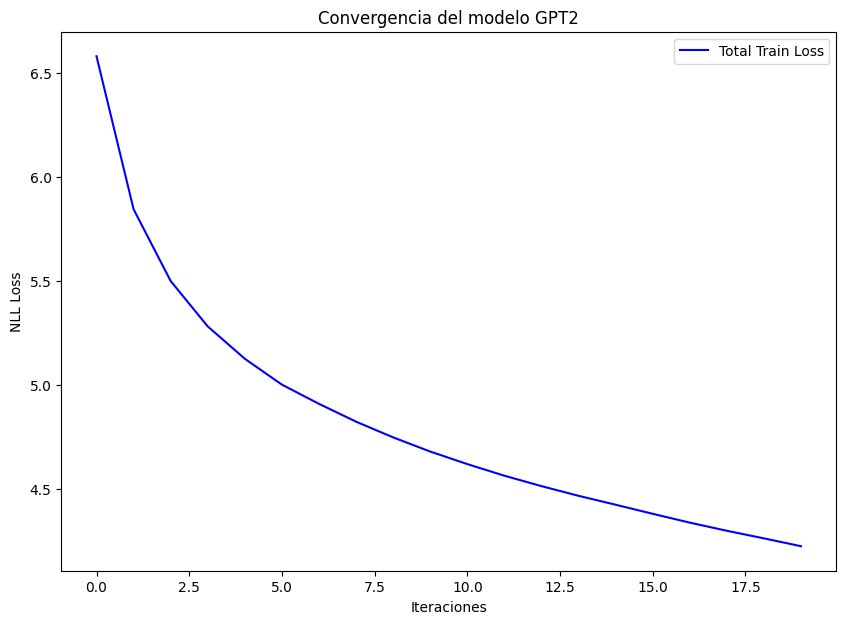

In [39]:
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(total_loss_train, "b", label="Total Train Loss")
plt.title("Convergencia del modelo GPT2", color="black")
ax1.set_xlabel("Iteraciones")

ax1.set_ylabel("NLL Loss", color="black")
ax1.legend(loc="upper right")
plt.show()

In [40]:
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [41]:
query = df_test['query'][0]
query

'Please plan a trip for me starting from Sarasota to Chicago for 3 days, from March 22nd to March 24th, 2022. The budget for this trip is set at $1,900.'

In [42]:
input_ids = tokenizer.encode(query, return_tensors="pt").to(device)

In [43]:
# Generate a sequence of tokens in response to the query
output_ids = model.generate(input_ids, max_length=440, num_beams=5, temperature=0.7, no_repeat_ngram_size=2)

# Decode the generated ids to get the answer text
answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [44]:
answer

'Please plan a trip for me starting from Sarasota to Chicago for 3 days, from March 22nd to March 24th, 2022. The budget for this trip is set at $1,900.Budget2403-\n\n:udget2303: 1udget:B0300B\nB 1B 2B 3B-B fromB toB  :  from  to, \n from, to: from to to,:art  Accommodation from\n to\n,\n  Arrival::, 1:raction,raction: Acc, Accraction Acc Acc\n Acc Day Acc:\n; ; Acc;,,;\nraction ation  Breakfast ommod\nDay,Day  Park, 2 Acc Park  in raction\nommod,ommod:ommod -!,  2, in,ation, Breakfast, Dinner, Self  Dinner zy, Park\n Park:;: 2  Self, Transportation Acc Transportation  3, 3 Acc from Acc to Acc 3: Park Acc 2: Self Acc Breakfast:Day: 3\n-:driving,driving: Transportation from: to 3-,- from 3 3  Transportation Transportation to Transportation: duration, duration: hours, mins, hours: mins: km, km: 12:364,364: 9:. art,art: 13: in:- Transportation\nart\n Transportation, cost '

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)